In [25]:
!pip install torchmetrics==0.11.4

In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchmetrics.classification import Accuracy, Precision, Recall, F1Score
from torchmetrics import MeanMetric
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=10, bias=True)
)

In [28]:
# 데이터
trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=trans)
val_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=trans)

In [29]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [30]:
# 모델
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

model.to(device)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=10, bias=True)
)

In [31]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [32]:
num_classes = 10

# 학습 지표
train_loss_metric = MeanMetric().to(device)
train_acc = Accuracy(task="multiclass", num_classes=num_classes).to(device)
train_precision = Precision(task="multiclass", num_classes=num_classes).to(device)
train_recall = Recall(task="multiclass", num_classes=num_classes).to(device)
train_f1 = F1Score(task="multiclass", num_classes=num_classes).to(device)

# 검증 지표
val_loss_metric = MeanMetric().to(device)
val_acc = Accuracy(task="multiclass", num_classes=num_classes).to(device)
val_precision = Precision(task="multiclass", num_classes=num_classes).to(device)
val_recall = Recall(task="multiclass", num_classes=num_classes).to(device)
val_f1 = F1Score(task="multiclass", num_classes=num_classes).to(device)

In [33]:
# 1. update → 배치마다
# 2. compute → 에포크 끝에 출력
# 3. reset → 출력 후에 초기화

# ----------------------------------------
# 학습 및 검증 루프
# ----------------------------------------
epochs = 10

#====== 시각화용 리스트 =======
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
train_precisions, val_precisions = [], []
train_recalls, val_recalls = [], []
train_f1s, val_f1s = [], []

for epoch in range(1, epochs + 1):
    print(f"\nEpoch {epoch}/{epochs}")

    # ======= TRAIN =======
    model.train()
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()

        # ======= update =======
        train_loss_metric.update(loss)
        train_acc.update(output, y)
        train_precision.update(output, y)
        train_recall.update(output, y)
        train_f1.update(output, y)

    # ======= VALIDATION =======
    model.eval()
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            output = model(x)
            loss = criterion(output, y)

            val_loss_metric.update(loss)
            val_acc.update(output, y)
            val_precision.update(output, y)
            val_recall.update(output, y)
            val_f1.update(output, y)
            
    # ======= compute ======= 
    train_loss = train_loss_metric.compute().item()
    val_loss = val_loss_metric.compute().item()
    train_acc_val = train_acc.compute().item()
    val_acc_val = val_acc.compute().item()
    train_prec_val = train_precision.compute().item()
    val_prec_val = val_precision.compute().item()
    train_recall_val = train_recall.compute().item()
    val_recall_val = val_recall.compute().item()
    train_f1_val = train_f1.compute().item()
    val_f1_val = val_f1.compute().item()
    
    # ======= 저장 =======
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc_val)
    val_accuracies.append(val_acc_val)
    train_precisions.append(train_prec_val)
    val_precisions.append(val_prec_val)
    train_recalls.append(train_recall_val)
    val_recalls.append(val_recall_val)
    train_f1s.append(train_f1_val)
    val_f1s.append(val_f1_val)

    # ======= 출력 =======
    print(f"[Train] Loss: {train_loss:.4f} | Acc: {train_acc_val:.4f} | Prec: {train_prec_val:.4f} | Recall: {train_recall_val:.4f} | F1: {train_f1_val:.4f}")
    print(f"[Val  ] Loss: {val_loss:.4f} | Acc: {val_acc_val:.4f} | Prec: {val_prec_val:.4f} | Recall: {val_recall_val:.4f} | F1: {val_f1_val:.4f}")

    # ======= metric reset =======
    for metric in [train_loss_metric, train_acc, train_precision, train_recall, train_f1,
                   val_loss_metric, val_acc, val_precision, val_recall, val_f1]:
        metric.reset()


Epoch 1/10
[Train] Loss: 0.4266 | Acc: 0.8747 | Prec: 0.8747 | Recall: 0.8747 | F1: 0.8747
[Val  ] Loss: 0.4038 | Acc: 0.8747 | Prec: 0.8747 | Recall: 0.8747 | F1: 0.8747

Epoch 2/10
[Train] Loss: 0.3312 | Acc: 0.9068 | Prec: 0.9068 | Recall: 0.9068 | F1: 0.9068
[Val  ] Loss: 0.3883 | Acc: 0.8856 | Prec: 0.8856 | Recall: 0.8856 | F1: 0.8856

Epoch 3/10
[Train] Loss: 0.3078 | Acc: 0.9165 | Prec: 0.9165 | Recall: 0.9165 | F1: 0.9165
[Val  ] Loss: 0.2825 | Acc: 0.9296 | Prec: 0.9296 | Recall: 0.9296 | F1: 0.9296

Epoch 4/10
[Train] Loss: 0.2955 | Acc: 0.9201 | Prec: 0.9201 | Recall: 0.9201 | F1: 0.9201
[Val  ] Loss: 0.3084 | Acc: 0.9214 | Prec: 0.9214 | Recall: 0.9214 | F1: 0.9214

Epoch 5/10
[Train] Loss: 0.2903 | Acc: 0.9236 | Prec: 0.9236 | Recall: 0.9236 | F1: 0.9236
[Val  ] Loss: 0.2982 | Acc: 0.9212 | Prec: 0.9212 | Recall: 0.9212 | F1: 0.9212

Epoch 6/10
[Train] Loss: 0.2871 | Acc: 0.9233 | Prec: 0.9233 | Recall: 0.9233 | F1: 0.9233
[Val  ] Loss: 0.3027 | Acc: 0.9332 | Prec: 0.933

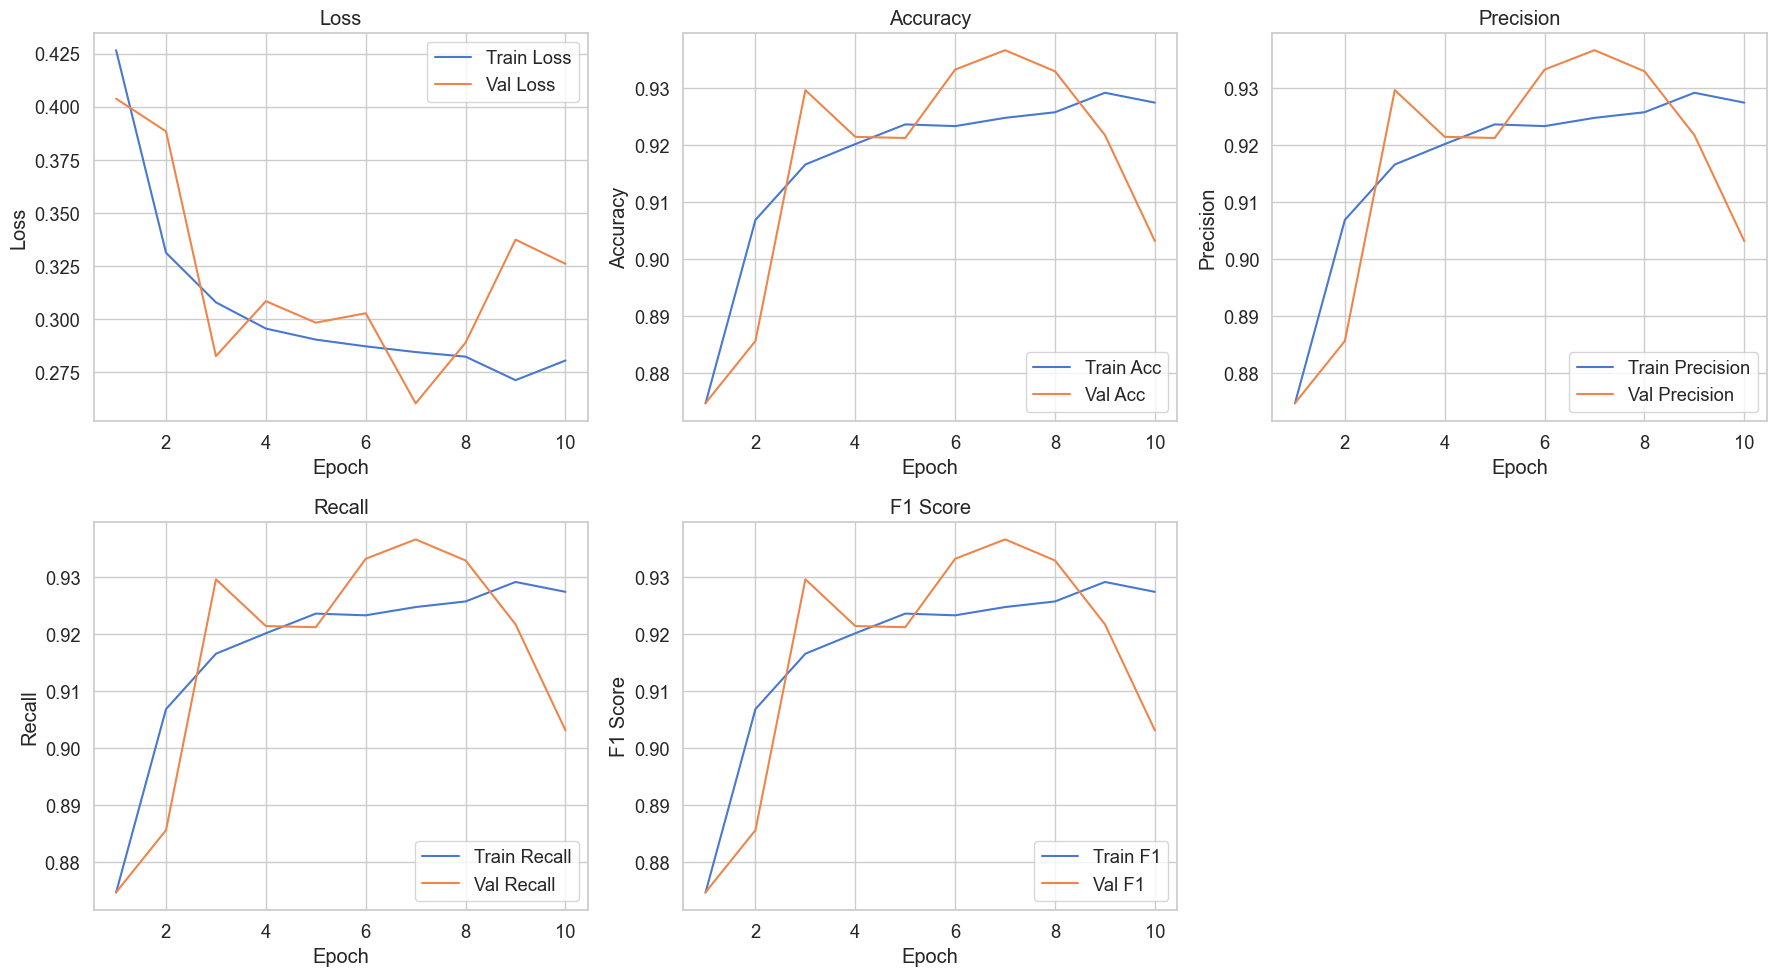

In [ ]:
###### 시각화 #########
sns.set(style="whitegrid", palette="muted", font_scale=1.2)

epochs_range = range(1, epochs + 1)
plt.figure(figsize=(18, 10))

plt.subplot(2, 3, 1)
plt.plot(epochs_range, train_losses, label="Train Loss")
plt.plot(epochs_range, val_losses, label="Val Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(2, 3, 2)
plt.plot(epochs_range, train_accuracies, label="Train Acc")
plt.plot(epochs_range, val_accuracies, label="Val Acc")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(2, 3, 3)
plt.plot(epochs_range, train_precisions, label="Train Precision")
plt.plot(epochs_range, val_precisions, label="Val Precision")
plt.title("Precision")
plt.xlabel("Epoch")
plt.ylabel("Precision")
plt.legend()

plt.subplot(2, 3, 4)
plt.plot(epochs_range, train_recalls, label="Train Recall")
plt.plot(epochs_range, val_recalls, label="Val Recall")
plt.title("Recall")
plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.legend()

plt.subplot(2, 3, 5)
plt.plot(epochs_range, train_f1s, label="Train F1")
plt.plot(epochs_range, val_f1s, label="Val F1")
plt.title("F1 Score")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.legend()

plt.tight_layout()
plt.show()

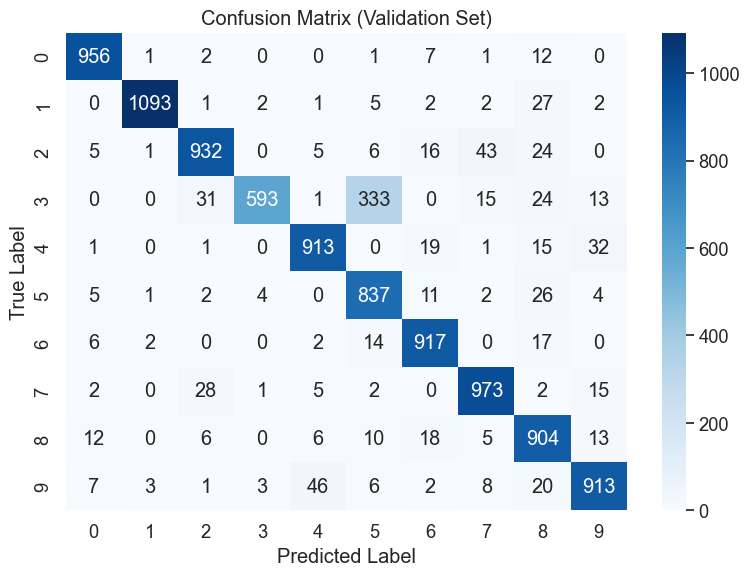

In [43]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 예측값과 실제값 모으기
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for x, y in val_loader:
        x, y = x.to(device), y.to(device)
        output = model(x)
        preds = torch.argmax(output, dim=1)
        all_preds.append(preds.cpu())
        all_labels.append(y.cpu())

# 텐서 연결 및 NumPy 변환
all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

# Confusion Matrix 계산
cm = confusion_matrix(all_labels, all_preds)

# Seaborn heatmap 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[str(i) for i in range(num_classes)],
            yticklabels=[str(i) for i in range(num_classes)])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Validation Set)')
plt.tight_layout()
plt.show()
